# Instacart: Analysis and Forecasting

by [Raul Maldonado](https://www.linkedin.com/in/raulm8)


**STILL IN DEVELOPMENT**

![InstaCart Logo](https://bloximages.chicago2.vip.townnews.com/pinalcentral.com/content/tncms/assets/v3/editorial/e/4c/e4cb9197-ddce-59e1-93c7-2868e145c705/5b858c3f5e8de.image.jpg?resize=400%2C212)

## 1. Introduction

**Background**:

Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.


From the Instacart Kaggle competition, the organization challenged the Kaggle community  to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. 


### Import

In [90]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

# Personal information via Localfile in
# the Resources/Admin folder.
import sys
sys.path.append("../Resources/Admin")
path = os.path.join('..','Resources','Data','RawData')

In [91]:
!ls ../Resources/Data/RawData

__MACOSX                  order_products__prior.csv products.csv
aisles.csv                order_products__train.csv sample_submission.csv
departments.csv           orders.csv


In [92]:
aislesDf = pd.read_csv(f'{path}/aisles.csv')
departmentsDf = pd.read_csv(f'{path}/departments.csv')
productsDf = pd.read_csv(f'{path}/products.csv')
ordersDf = pd.read_csv(f'{path}/orders.csv')
order_products_prior = pd.read_csv(f'{path}/order_products__prior.csv')
order_products_train = pd.read_csv(f'{path}/order_products__train.csv')

In [93]:
ordersDf_prior = ordersDf[ordersDf['eval_set']=='prior']

## 2. Analysis

### EDA

We explore the various data of orders and product related characteristics to find patterns and habits from users purchases. This analysis alllows us to go more in-depth into finding potential discoverable insights in determining re-order classification for future purchases

**Preliminary EDA thoughts:**
* What are the top products ordered from users?
* What is the average basket of each order?
* What is the ranking of users total orders in dataset?
  * What is the average number of orders?
* What is the timeline for this dataset?
* What is the average basket price for each order?
* What is the total spend from users?
* Is there any noticeable geographical information to segment from?
* Can we identify the popular aisles?

What determines re-order? Type of product? Common essentials from specific aisles or departments? 

Does having a specific time of the day impact the re-ordering probability?

Since this is more of re-ordering probability (yes or no), can we have a supervised classification algorithm implemented for this project? There isn't a clearly defined structure of features, so curious about decision tree or random forest implementation.


#### Average Order Size

In [96]:
numOrders_perUser = ordersDf[['order_id','user_id']].groupby('user_id').count() \
                          .sort_values('order_id',ascending=False)
numOrders_perUser.columns = ['User Count']

,User Count
user_id,
152340,100
185641,100
185524,100
81678,100
70922,100
136870,100
81704,100
119932,100
119835,100


In [ ]:
numOrders_perUser[:10]

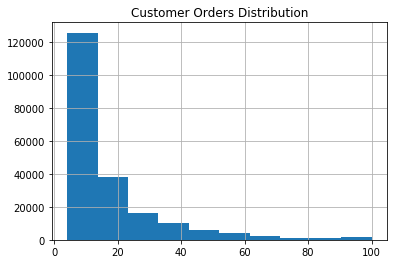

          User Count
count  206209.000000
mean       16.590367
std        16.654774
min         4.000000
25%         6.000000
50%        10.000000
75%        20.000000
max       100.000000

Average number of users: 16


In [104]:
numOrders_perUser.hist()
plt.title('Customer Orders Distribution')
plt.show()


ordersUsersSummary = numOrders_perUser.describe()
print(ordersUsersSummary)
print(f'''\nAverage Order Size: {int(ordersUsersSummary.loc['mean'])}''')

#### Top 15 Purchased Products

In [105]:
ordersJoinedProductNames_df = order_products_prior.merge(productsDf,on=[ \
                                  'product_id','product_id'], how='inner')

In [106]:
ordersJoinedProductNames_byProduct = ordersJoinedProductNames_df[ \
                                     ['product_name','order_id']].groupby('product_name') \
                                         .count().sort_values('order_id',ascending=False)
ordersJoinedProductNames_byProduct.columns = ['Product Count']

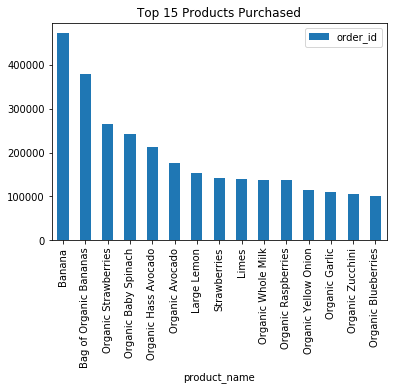

                        order_id
product_name                    
Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905


In [108]:
ordersJoinedProductNames_byProduct[:15].plot(kind='bar')
plt.title('Top 15 Products Purchased')
plt.ylabel('Purchase Count (1e7)')
plt.show()

print(ordersJoinedProductNames_byProduct[:10])

Top products purchased by users were more towards essential produce or other essentials ranging from 137,000-470,00. It would be insightsful to determine what products would and are going to be top purchases from signals like pricing or "essential" food rating. (i.e. More analysis could be carried in here for evaluation of association to predicting re-ordering likelihood)

#### Top 15 Purchased Products by Aisle

In [111]:
orders_JoinProductsAndDepartments = order_products_prior.merge( \
        productsDf, on=['product_id','product_id'],how='inner') \
        .merge(departmentsDf, on =['department_id','department_id'], \
        how='left')

In [140]:
orders_JoinProductsAndAisles_grouped = orders_JoinProductsAndDepartments[ \
        ['order_id','aisle_id']] \
        .groupby(['aisle_id']).count().reset_index( \
        'aisle_id',drop=False).sort_values('order_id',ascending=False)
orders_JoinProductsAndAisles_grouped.set_index('aisle_id',inplace = True)
orders_JoinProductsAndAisles_grouped.columns = ['Aisle Count']

In [141]:
orders_JoinProductsAndAisles_grouped.head()

,Aisle Count
aisle_id,
24,3642188
83,3418021
123,1765313
120,1452343
21,979763


In [146]:
ordersAisleDF = orders_JoinProductsAndAisles_grouped.merge( \
                    aislesDf,on=['aisle_id','aisle_id'],how='inner')[['aisle','Aisle Count']]

In [150]:
ordersAisleDF.set_index('aisle',inplace=True)

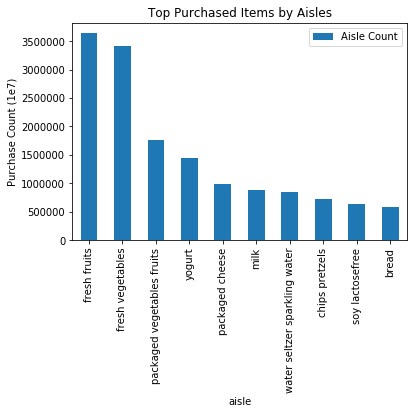

                               Aisle Count
aisle                                     
fresh fruits                       3642188
fresh vegetables                   3418021
packaged vegetables fruits         1765313
yogurt                             1452343
packaged cheese                     979763
milk                                891015
water seltzer sparkling water       841533
chips pretzels                      722470
soy lactosefree                     638253
bread                               584834


In [152]:
ordersAisleDF[:10].plot(kind='bar')
plt.title('Top Purchased Items by Aisles')
plt.ylabel('Purchase Count (1e7)')
plt.show()

print(ordersAisleDF[:10])

#### Top Department-related orders

In [12]:
orders_JoinProductsAndDepartments = order_products_prior.merge(productsDf,on=['product_id','product_id'],how='inner') \
                    .merge(departmentsDf, on =['department_id','department_id'], \
                           how='left')

In [13]:
orders_JoinProductsAndDepartments_grouped = orders_JoinProductsAndDepartments[['order_id','department_id','department']] \
        .groupby(['department_id','department']).count().reset_index( \
        'department_id',drop=True).sort_values('order_id',ascending=False)
orders_JoinProductsAndDepartments_grouped.columns = ['Department Count']

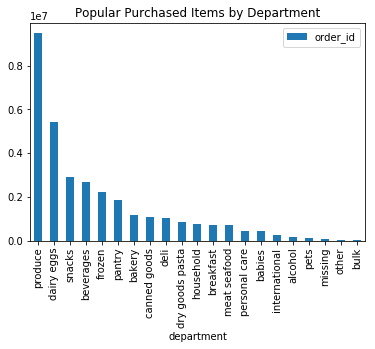

In [14]:
orders_JoinProductsAndDepartments_grouped.plot(kind='bar')
plt.title('Top Purchased Items by Department')
plt.ylabel('Purchase Count (1e7)')
plt.show()

print(orders_JoinProductsAndDepartments_grouped[:10])

**Thoughts so far**

Focusing on a product-centric analysis through segementation of Products, Aisles, and Departments, we find the following:


For more exploration, what other factors could be associated with a good chance in a product's probability for re-ordering? If you notice, we can identify a time-series segementation for further analysis by using day of the week (DoW), Time of Day, or other time signals/features.

Moreover, can we gauge re-order ratio for time related segmentations?

#### Event/Time Segmentation

##### Orders and Day of the Week

In [162]:
ordersAndProducts_TimeDf = order_products_prior.merge( \
        ordersDf_prior, how='left', on =['order_id','order_id'])\
        .merge(productsDf, how='left', on =['product_id','product_id'])


In [170]:
orders_timeDf_nonDuplicates = ordersAndProducts_TimeDf.drop_duplicates('order_id')[[\
        'order_id','order_dow']]
orders_timeDf_nonDuplicates.reset_index(inplace=True,drop = True)

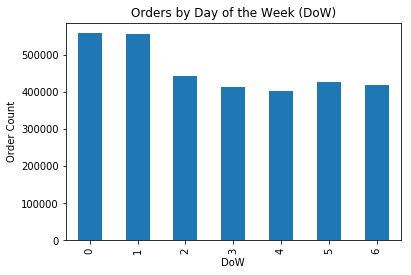

In [180]:
orders_timeDf_nonDuplicates.groupby(['order_dow'])\
        .count()\
        .plot(kind='bar',legend =False)
plt.title('Orders by Day of the Week (DoW)')
plt.ylabel('Order Count')
plt.xlabel('DoW')
plt.show()

##### Orders and Time of Day

In [184]:
orders_timeDf_nonDuplicates_ohod = ordersAndProducts_TimeDf.drop_duplicates('order_id')[[\
        'order_id','order_hour_of_day']]
orders_timeDf_nonDuplicates_ohod.reset_index(inplace=True,drop = True)

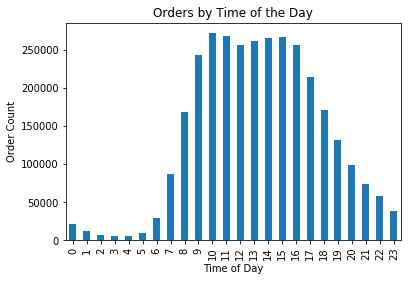

In [185]:
orders_timeDf_nonDuplicates_ohod.groupby(['order_hour_of_day'])\
        .count()\
        .plot(kind='bar',legend =False)
plt.title('Orders by Time of the Day')
plt.ylabel('Order Count')
plt.xlabel('Time of Day')
plt.show()

In [186]:
## Get segmentation by Day of the week and time of the day for particular products, top of them
ordersAndProducts_TimeDf.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id'],
      dtype='object')

Note:

WORK ON visualization with colors as Morning, Afternoon, evening

Work on visualization execution segmentation

##### Top Products by Time of the Day

In [188]:
orders_timeDf_ohod = ordersAndProducts_TimeDf[[\
        'order_id','order_hour_of_day','product_name']]
orders_timeDf_ohod.reset_index(inplace=True,drop = True)

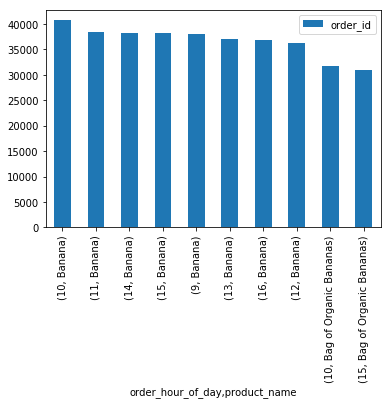

In [197]:
orders_timeDf_ohod.groupby(['order_hour_of_day','product_name'])\
        .count().sort_values('order_id',ascending=False)[:10]\
        .plot(kind='bar')

In [ ]:
orders_timeDf_ohod.groupby(['order_hour_of_day','product_name'])\
        .count()\
        .plot(kind='bar',legend =False)
plt.title('Orders by Time of the Day')
plt.ylabel('Order Count')
plt.xlabel('Time of Day')
plt.show()

##### Top Products by Day of the Week

In [198]:
TODO

NameError: name 'TODO' is not defined

#### Top Non-reordered Products

In [ ]:
Thought: Overall re-ordered, or top products from only re-ordered products only

In [15]:
orderProducts_withProduct = order_products_prior.merge(productsDf, \ 
                            on=['product_id','product_id'], how ='inner')

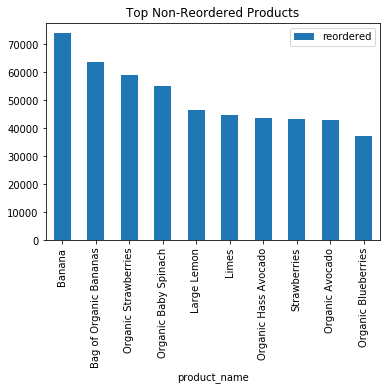

In [53]:
orderProducts_withProduct_nonreordered = orderProducts_withProduct[orderProducts_withProduct[ \
                                'reordered']==0]
orderProducts_withProduct_nonreordered[['product_name','reordered']].groupby( \
                            'product_name').count().reset_index() \
                            .sort_values(['reordered','product_name'], ascending=False) \
                            .set_index('product_name')[:10].plot(kind='bar')
plt.title('Top Non-Reordered Products')
plt.show()

#### Top Re-ordered Products

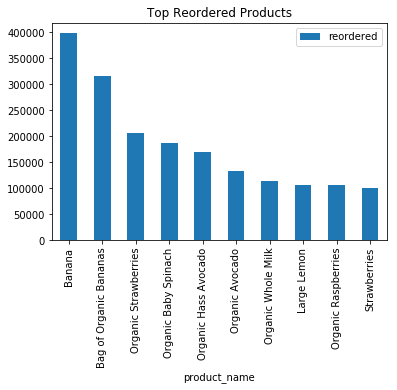

In [52]:
orderProducts_withProduct_reordered = orderProducts_withProduct[orderProducts_withProduct[ \
                                'reordered']==1]
orderProducts_withProduct_reordered[['product_name','reordered']].groupby( \
                            'product_name').count().reset_index() \
                            .sort_values('reordered', ascending=False) \
                            .set_index('product_name')[:10].plot(kind='bar')
plt.title('Top Reordered Products')
plt.show()

In [17]:
productsDf.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### Top Re-ordered Products by certain segments Aisle and Department


##### Aisle DrillDown

In [63]:
orderProducts_withProduct.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [65]:
orderProducts_withProductAisleDepart = orderProducts_withProduct.merge(\
                                    aislesDf,how='left',on=['aisle_id','aisle_id']).merge( \
                                    departmentsDf,how='left',on=['department_id', 'department_id'])

In [70]:
orderProducts_consolidation = orderProducts_withProductAisleDepart[\
                                    ['order_id', 'add_to_cart_order','reordered',
                                     'product_name','aisle','department']]

orderProducts_AisleRatio = orderProducts_consolidation[['reordered','aisle']].groupby('aisle').sum() /\
    orderProducts_consolidation[['reordered','aisle']].groupby('aisle').count()

,reordered
aisle,
air fresheners candles,0.309052
asian foods,0.351132
baby accessories,0.550980
baby bath body care,0.295770
baby food formula,0.590259
bakery desserts,0.499125
baking ingredients,0.305082
baking supplies decor,0.167229
beauty,0.212062


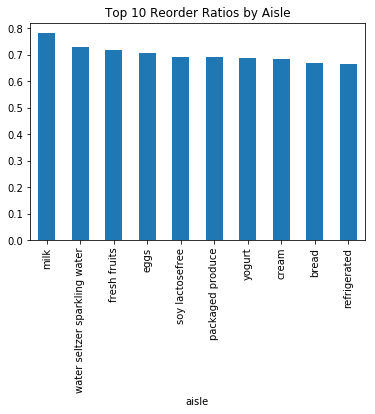

In [82]:
orderProducts_AisleRatio.reset_index().sort_values('reordered',\
                                ascending=False).set_index('aisle')[:10].plot(kind='bar',legend=False)
plt.title('Top 10 Reorder Ratios by Aisle')
plt.show()

##### Department DrillDown

In [83]:
orderProducts_consolidation = orderProducts_withProductAisleDepart[\
                                    ['order_id', 'add_to_cart_order','reordered',
                                     'product_name','aisle','department']]

orderProducts_DeptRatio = orderProducts_consolidation[['reordered','department']].groupby('department').sum() /\
    orderProducts_consolidation[['reordered','department']].groupby('department').count()




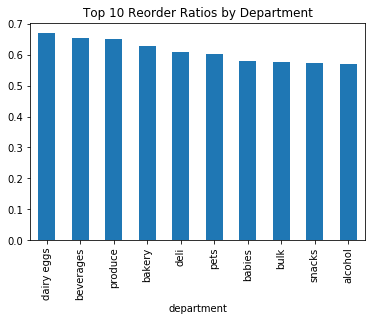

In [86]:
orderProducts_DeptRatio.reset_index().sort_values('reordered',\
                                ascending=False).set_index('department')[:10].plot(kind='bar',legend=False)
plt.title('Top 10 Reorder Ratios by Department')
plt.show()

##### Product DrillDown

In [88]:
orderProducts_consolidation = orderProducts_withProductAisleDepart[\
                                    ['order_id', 'add_to_cart_order','reordered',
                                     'product_name','aisle','department']]

orderProducts_ProductRatio = orderProducts_consolidation[['reordered','product_name']].groupby('product_name').sum() /\
    orderProducts_consolidation[['reordered','product_name']].groupby('product_name').count()

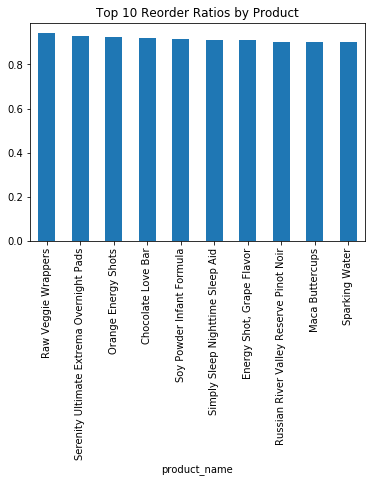

In [89]:
orderProducts_ProductRatio.reset_index().sort_values('reordered',\
                                ascending=False).set_index('product_name')[:10].plot(kind='bar',legend=False)
plt.title('Top 10 Reorder Ratios by Product')
plt.show()

In [ ]:
Dow?

In [ ]:
Time of day?

#### Re-identifying Characteristics for determination of modeling


##### Final evaluation of model and characteristics

In [ ]:

What is the Re-order ratio for certain basket sizes?
 ------For the grouping of basket sizes, find the total that are re-ordered from the actual total
 
 
Time of day for reorder. ( Group by Time of day then get count of re-orders)

Thoughts:

We want to identify/predict for what products would be re-ordered. 

For something to be re-ordered, we need to identify characteristics of what the user would order. 

Different users have different preferences. However, they do have a main baseline of essential foods to purchase whenever they shop. 

Moreover, with the convenience of Instacart, is it possible there is an indlux of other items than traditional grocery shopping purchases

### A/B Testing


* A/B Testing
    * For people in the "prior" eval_set, What was the average spend? From this average spend, can we identify if it's different from a hypothetical average of 10+ that value?
    
    * Let's grab a sample of the sample of prior * train people and top product. We investigate the datasets distributions. If the variances appear to be different, perform a test of determing if variances are quite different from each other

## 3. Forecasting

* Forecasting (Regression)
    * Can we do regression on that group?
____

* What are the observed differences between returning shoppers and new shoppers?

* Is there a major diference between the total average of orders from a particular segmented SRS from the population?

* What can we identify as top product purchases? From these product purchases, do they belong in:
    * a particular aisle
    * part of a particular line/group of products?
    * are noticeably purchased in a certain dow or other timeframe?

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
#Obtain Orders Training Data
## completed near top of the page ^^^

# Obtain Orders Test Data 
ordersDf_test = ordersDf[ordersDf=['eval_set']=='test']

In [42]:
orderProducts_withOrders = order_products_train.merge(ordersDf_prior, on= \
                                         ['order_id','order_id'],how='inner')

In [43]:
features = orderProducts_withOrders[['days_since_prior_order','order_dow', \
                                     'order_hour_of_day','reordered']] \
      [:1000]

In [44]:
target = orderProducts_withOrders['product_id'][:1000]

In [45]:
model = LogisticRegression()

In [46]:
model.fit(features,target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [48]:
ordersDf_testOnly = ordersDf[ordersDf['eval_set']=='test'][:10]
ordersDf_testOnly.head()
orderProducts_withOrders = order_products_train.merge(ordersDf_testOnly, on= \
                                         ['order_id','order_id'],how='inner')


features = orderProducts_withOrders[['days_since_prior_order','order_dow', \
                                     'order_hour_of_day','reordered']] \
      [:1000]
# model.predict(ordersDf_testOnly)


## Resources

[Starting with Postgres](https://www.codementor.io/engineerapart/getting-started-with-postgresql-on-mac-osx-are8jcopb)

[Postgres via SQLAlchemy](https://www.compose.com/articles/using-postgresql-through-sqlalchemy/)